pip install qrisp 

https://www.qrisp.eu

DB-QITE implementation in Qrisp: https://qrisp.eu/reference/Algorithms/QITE.html

Experiments performed on QITE_experiments branch: https://github.com/eclipse-qrisp/Qrisp/tree/QITE_experiments with lowered simulator cutoff_ratio for high precision state vector simulations


In [1]:
from qrisp import QuantumVariable
from qrisp.vqe import VQEProblem
from qrisp.vqe.problems.heisenberg import create_heisenberg_init_function

import networkx as nx
import numpy as np

import pickle
from datetime import datetime

from run_QITE import run_QITE

def save_data(data, filename):  
    # Open a file for writing
    with open(filename+'.pickle', 'wb') as file:
        # Write the object to the file
        pickle.dump(data, file)

def load_data(filename):
    with open(filename+'.pickle', 'rb') as file:
        # Load the object from the file
        data = pickle.load(file)
    return data

/home/marek/.local/lib/python3.12/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


# Heisenberg XXX model

$$ H_{\text{TFIM}} = \sum_{j=0}^{L-1}(X_jX_{j+1}+Y_jY_{j+1}+Z_jZ_{j+1}) $$

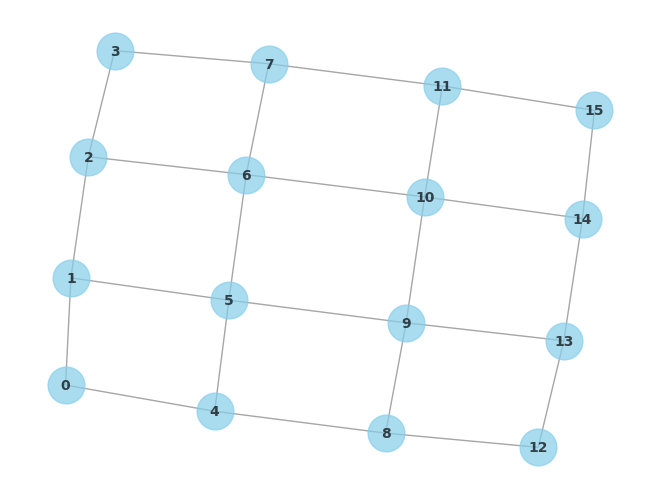

In [2]:
from qrisp.operators import X, Y, Z

L = 16
G = nx.Graph()
G.add_edges_from([(0,1),(1,2),(2,3),
       (0,4),(1,5),(2,6),(3,7),
       (4,8),(9,5),(10,6),(11,7),        
       (8,12),(9,13),(10,14),(11,15),
        (4,5),(5,6),(6,7),
        (8,9),(9,10),(10,11),
        (12,13),(13,14),(14,15)
       ])
nx.draw(G, with_labels=True,
            node_color='skyblue', node_size=700,
            font_size=10, font_weight='bold',
            edge_color='gray', alpha=0.7)

In [3]:
H = sum((X(i)*X(j)+Y(i)*Y(j)+Z(i)*Z(j)) for i,j in G.edges()
       )
print(H)

# Define scaling factor
alpha = 10

# Hamiltonian simulation via second order Suzuki-Trotter formula with 2 steps
def exp_H(qv, t):
    H.trotterization(order=2, method='commuting')(qv, t/alpha, 2)

X(0)*X(1) + X(0)*X(4) + X(1)*X(2) + X(1)*X(5) + X(10)*X(11) + X(10)*X(14) + X(11)*X(15) + X(12)*X(13) + X(13)*X(14) + X(14)*X(15) + X(2)*X(3) + X(2)*X(6) + X(3)*X(7) + X(4)*X(5) + X(4)*X(8) + X(5)*X(6) + X(5)*X(9) + X(6)*X(10) + X(6)*X(7) + X(7)*X(11) + X(8)*X(12) + X(8)*X(9) + X(9)*X(10) + X(9)*X(13) + Y(0)*Y(1) + Y(0)*Y(4) + Y(1)*Y(2) + Y(1)*Y(5) + Y(10)*Y(11) + Y(10)*Y(14) + Y(11)*Y(15) + Y(12)*Y(13) + Y(13)*Y(14) + Y(14)*Y(15) + Y(2)*Y(3) + Y(2)*Y(6) + Y(3)*Y(7) + Y(4)*Y(5) + Y(4)*Y(8) + Y(5)*Y(6) + Y(5)*Y(9) + Y(6)*Y(10) + Y(6)*Y(7) + Y(7)*Y(11) + Y(8)*Y(12) + Y(8)*Y(9) + Y(9)*Y(10) + Y(9)*Y(13) + Z(0)*Z(1) + Z(0)*Z(4) + Z(1)*Z(2) + Z(1)*Z(5) + Z(10)*Z(11) + Z(10)*Z(14) + Z(11)*Z(15) + Z(12)*Z(13) + Z(13)*Z(14) + Z(14)*Z(15) + Z(2)*Z(3) + Z(2)*Z(6) + Z(3)*Z(7) + Z(4)*Z(5) + Z(4)*Z(8) + Z(5)*Z(6) + Z(5)*Z(9) + Z(6)*Z(10) + Z(6)*Z(7) + Z(7)*Z(11) + Z(8)*Z(12) + Z(8)*Z(9) + Z(9)*Z(10) + Z(9)*Z(13)


## DB-QITE with Singlet and HVA warm-start

In [5]:
# Tensor product of singlet states
M = nx.maximal_matching(G)
U_singlet = create_heisenberg_init_function(M)

# HVA
H0 = sum((X(i)*X(j)+Y(i)*Y(j)+Z(i)*Z(j)) for i,j in M)
H1 = sum((X(i)*X(j)+Y(i)*Y(j)+Z(i)*Z(j)) for i,j in set(G.edges())-M)

def ansatz(qv, theta):
    # Rescaling t->1/4 equivalent to choosing rescaled inital parameters for HVA
    H1.trotterization(method='commuting')(qv, t=theta[1]/4)
    H0.trotterization(method='commuting')(qv, t=theta[0]/4)

HVA = VQEProblem(H, ansatz, 2, init_function=U_singlet)
U_HVA = HVA.train_function(QuantumVariable(G.number_of_nodes()), depth=1, max_iter=100)

# Calculate energy for HVA
def state_prep():
    qv = QuantumVariable(L)
    U_HVA(qv)
    return qv

print(H.expectation_value(state_prep)())

results = []

results.append(run_QITE(H, U_singlet, exp_H, np.linspace(.01,1.5,10), 4, method='GC', use_statevectors=True))
results.append(run_QITE(H, U_HVA, exp_H, np.linspace(.01,1.5,10), 4, method='GC', use_statevectors=True))

-33.10435298316819                                                                   


In [6]:
# Save benchmark data
current_datetime = datetime.now()
date_time_string = current_datetime.strftime("%m-%d-%H")
save_data(results,'data/benchmarks_2nd_L='+str(L)+'_2d_'+date_time_string)